In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
import pickle

sns.set()
sns.set_style('whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from scipy.stats import sem


In [2]:
def compute_missing_mean_se(data):
    mean, std = [], []
    for i in range(data.shape[0]):
        temp = []
        for j in range(data.shape[1]):
                    temp.append(data[i, j])
        temp = np.array(temp)
        mean.append(np.mean(temp))
        std.append(np.std(temp))
    return np.array(mean), np.array(std)/np.sqrt(data.shape[0])

def compute_mean_se(data, x='meo_mp', y='acc_mp'):
    acc_mp_mean, acc_mp_se = compute_missing_mean_se(data[y])
    fr_mp_mean, fr_mp_se = compute_missing_mean_se(data[x])
    return [fr_mp_mean, acc_mp_mean, fr_mp_se, acc_mp_se]

def plot_point(ax, data, x, y, label, marker, color):
    ax.errorbar(data[x+'_mean'], data[y+'_mean'], xerr=data[x+'_std']/np.sqrt(10), yerr=data[y+'_std']/np.sqrt(10), marker=marker, label = label, color=color)

def plot_multi(ax, data, x, y, idx, label, marker, color):
    ax.errorbar(np.array(data[x+'_mean'])[idx], np.array(data[y+'_mean'])[idx], 
                xerr=np.array(data[x+'_std'])[idx]/np.sqrt(10), yerr=np.array(data[y+'_std'])[idx]/np.sqrt(10), marker=marker, label = label, color=color)

def plot_leverage(ax, data, x, y, label, marker, color):
    ax.errorbar(data[x].mean(), data[y].mean(), 
                xerr=data[x].std()/np.sqrt(10), yerr=data[y].std()/np.sqrt(10), marker=marker, label = label, color=color)
    return

def plot_FACT(ax, data, idx, label, marker, color):
    x = np.array([np.mean(data['meo'][i]) for i in range(len(data['meo']))])
    y = np.array([np.mean(data['acc'][i]) for i in range(len(data['acc']))])
    xerr = np.array([sem(data['meo'][i]) for i in range(len(data['meo']))])
    yerr = np.array([sem(data['acc'][i]) for i in range(len(data['acc']))])
    ax.errorbar(x[idx], y[idx], xerr=xerr[idx], yerr=yerr[idx], marker=marker, label = label, color=color)
    # ax.errorbar(x=np.mean(data['meo'], axis=1), y= np.mean(data['acc'], axis=1), xerr=sem(data['meo'], axis=1), yerr=sem(data['acc'], axis=1), marker=marker, label = label, color=color)
    return 
    
def plot_mp(ax, data, x, y, idx, label, marker, color):
    mean_se = compute_mean_se(data, x, y)
    ax.errorbar(np.abs(mean_se[0][idx]), mean_se[1][idx], xerr=mean_se[2][idx]/np.sqrt(10), yerr=mean_se[3][idx]/np.sqrt(10), 
                marker=marker, label = label, color=color, markersize=5)
    return

def plot_base(ax, x, y, label):
    ax.plot(x, y, marker='*', linestyle = '', markersize=10, color='black', label=label, zorder=10)
    return 


def get_model_name(model):
    if (model == 'rf') or (model == 'rfc'):
        model_name = 'Random Forest'
    elif model == 'logit':
        model_name = 'Logistic Regression'
    elif model == 'gbm':
        model_name = 'GBM'
        
    return model_name

In [3]:
def basic_plot(data, idx, model, ax=None, fair='eo', mp_name='ce'):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
    mp_all = data['mp_all']
    
    if fair == 'eo':
        ## Hardt
        plot_point(ax, data['hardt'], 'abseo', 'acc', 'EqOdds', 'o', 'steelblue')
        ## rejection
        if 'rejection' in data.keys():
            plot_multi(ax, data['rejection'], 'abseo', 'acc', idx['rejection'], 'Rejection', 'o', 'gold')
        ## reduction
        plot_multi(ax, data['reduction'], 'abseo', 'acc', idx['reduction'], 'Reduction', 'o', 'coral')
        ## calibration
        if 'calibration' in data.keys():
            plot_point(ax, data['calibration'], 'abseo', 'acc', 'CalEqOdds', 'o', 'darkgoldenrod')
        if 'fact' in data.keys():
            plot_FACT(ax, data['fact'], idx['fact'], 'FACT', 'o', 'gray')
        ## Leveraging
        plot_leverage(ax, data['leverage'], 'meo', 'acc',  'LevEqOpp', 'o', 'darkolivegreen')
        ## Model Projection
        if model == 'rf':
            model = 'rfc'
        
        if mp_name == 'ce': 
            mp = mp_all[model+'_ce_meo']
            plot_mp(ax, mp, 'meo_abs', 'acc', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
        elif mp_name == 'kl':
            mp = mp_all[model+'_kl_meo']
            plot_mp(ax, mp, 'meo_abs', 'acc', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        elif mp_name == 'all':
            mp = mp_all[model+'_ce_meo']
            plot_mp(ax, mp, 'meo_abs', 'acc', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
            mp = mp_all[model+'_kl_meo']
            plot_mp(ax, mp, 'meo_abs', 'acc', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        ## Base
        if 'original' in data.keys():
            plot_base(ax, x = data['original']['abseo_mean'], y = data['original']['acc_mean'], label= 'Base')
        else:
            plot_base(ax, x=mp['meo_abs'].mean(axis=1)[idx['mp'][-1]], y=mp['acc'].mean(axis=1)[idx['mp'][-1]], label='Base')
        
    elif fair == 'maxeo':
        ## Hardt
        plot_point(ax, data['hardt'], 'maxeo', 'acc', 'EqOdds', 'o', 'orange')
        ## rejection
        # plot_multi(ax, data['rejection'], 'abseo', 'acc', idx['rejection'], 'Rejection', 'o', 'gold')
        ## reduction
        # plot_multi(ax, data['reduction'], 'abseo', 'acc', idx['reduction'], 'Reduction', 'o', 'orangered')
        ## calibration
        # if 'calibration' in data.keys():
            # plot_point(ax, data['calibration'], 'abseo', 'acc', 'CalEqOdds', 'o', 'darkgoldenrod')
        ## Leveraging
        plot_leverage(ax, data['leverage'], 'maxeo', 'acc',  'LevEqOpp', 'o', 'darkolivegreen')
        ## Model Projection
        if model == 'rf':
            model = 'rfc'
        
        if mp_name == 'ce': 
            mp = mp_all[model+'_ce_meo']
            plot_mp(ax, mp, 'mo', 'acc', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
        elif mp_name == 'kl':
            mp = mp_all[model+'_kl_meo']
            plot_mp(ax, mp, 'mo', 'acc', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        elif mp_name == 'all':
            mp = mp_all[model+'_ce_meo']
            plot_mp(ax, mp, 'mo', 'acc', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
            mp = mp_all[model+'_kl_meo']
            plot_mp(ax, mp, 'mo', 'acc', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        ## Base
        plot_base(ax, x=mp['mo'].mean(axis=1)[idx['mp'][-1]], y=mp['acc'].mean(axis=1)[idx['mp'][-1]], label='Base')

    elif fair == 'sp': 
        ## rejection
        if 'rejection' in data.keys():
            plot_multi(ax,  data['rejection'], 'sp', 'acc', idx['rejection'], 'Rejection', 'o', 'gold')
        ## reduction
        plot_multi(ax, data['reduction'], 'sp', 'acc', idx['reduction'], 'Reduction', 'o', 'coral')
        ## Model Projection
        if model == 'rf':
            model = 'rfc'
        if mp_name == 'ce': 
            mp = mp_all[model+'_ce_sp']
            plot_mp(ax, mp, 'sp', 'acc', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
        elif mp_name == 'kl':
            mp = mp_all[model+'_kl_sp']
            plot_mp(ax, mp, 'sp', 'acc', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        elif mp_name == 'all':
            mp = mp_all[model+'_ce_sp']
            plot_mp(ax, mp, 'sp', 'acc', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
            mp = mp_all[model+'_kl_sp']
            plot_mp(ax, mp, 'sp', 'acc', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        ## Base
        
        if 'original' in data.keys():
            plot_base(ax, x = data['original']['sp_mean'], y = data['original']['acc_mean'], label= 'Base')
        else:
            plot_base(ax, x=mp['sp'].mean(axis=1)[idx['mp'][-1]], y=mp['acc'].mean(axis=1)[idx['mp'][-1]], label='Base')
                
    elif fair == 'brier': 
        ## rejection
        plot_multi(ax,  data['rejection'], 'sp', 'brier', idx['rejection'], 'Rejection', 'o', 'gold')
        ## reduction
        plot_multi(ax, data['reduction'], 'sp', 'brier', idx['reduction'], 'Reduction', 'o', 'orangered')
        ## Model Projection
        if model == 'rf':
            model = 'rfc'
        if mp_name == 'ce': 
            mp = mp_all[model+'_ce_sp']
            plot_mp(ax, mp, 'sp', 'brier', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
        elif mp_name == 'kl':
            mp = mp_all[model+'_kl_sp']
            plot_mp(ax, mp, 'sp', 'brier', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        elif mp_name == 'all':
            mp = mp_all[model+'_ce_sp']
            plot_mp(ax, mp, 'sp', 'brier', idx['mp'], 'FairProjection-CE', 'o', 'darkred')
            mp = mp_all[model+'_kl_sp']
            plot_mp(ax, mp, 'sp', 'brier', idx['mp'], 'FairProjection-KL', 'x', 'darkred')
        ## Base
        plot_base(ax, x=mp['sp'].mean(axis=1)[idx['mp'][-1]], y=mp['brier'].mean(axis=1)[idx['mp'][-1]], label='Base')

    ## Figure configs
    ax.set_ylabel('Accuracy')
    if fair == 'eo':
        ax.set_xlabel('Mean Equalized Odds')
    elif fair == 'maxeo':
        ax.set_xlabel('Max Equalized Odds')
    elif fair == 'sp':
        ax.set_xlabel('Statistical Parity')
        


## Adult Dataset

In [4]:
def load_adult_plots(model, fair='eo'):
    ## benchmarks
    with open('adult/results/eqodds_'+model+'_s42_.pkl', 'rb+') as f: 
        adult_eqodds = pickle.load(f)
    with open('adult/results/original_'+model+'_s42_.pkl', 'rb+') as f: 
        adult_original = pickle.load(f)
    with open('adult/results/reduction_'+model+'_s42_eo.pkl', 'rb+') as f: 
        adult_reduction_eo = pickle.load(f)
    with open('adult/results/reduction_'+model+'_s42_sp.pkl', 'rb+') as f: 
        adult_reduction_sp = pickle.load(f) 
    with open('adult/results/roc_'+model+'_s42_eo.pkl', 'rb+') as f: 
        adult_roc_eo = pickle.load(f)
    with open('adult/results/roc_'+model+'_s42_sp.pkl', 'rb+') as f: 
        adult_roc_sp = pickle.load(f)
        
    with open('adult/results/leveraging_'+model+'_s42_eo.pkl', 'rb+') as f: 
        adult_leverage = pickle.load(f)

    ## Model Projection
    with open('adult/results/adult-mp-new.pkl', 'rb+') as f: 
        adult_mp = pickle.load(f)
        
    if model == 'rf':
        model = 'rfc'
   
    adult_tolerance = adult_mp['tolerance']
    
    if fair == 'eo':
        return adult_eqodds, adult_reduction_eo, adult_roc_eo, adult_leverage, adult_mp, adult_original, adult_tolerance
        
    else: 
        return None, adult_reduction_sp, adult_roc_sp, None, adult_mp, adult_original, adult_tolerance
        

def plot_adult(hardt, reduction, rejection, leverage, mp_all, original, tolerance, model, ax =None, fair='eo', mp_name='ce'):
    if fair == 'sp':
        idx_projection = np.array([4,5,6,7]) #np.arange(len(tolerance))
    else: 
        idx_projection = np.arange(len(tolerance))
    idx_rejection = np.arange(10)
    idx_reduction = np.array([0, 2, 3, 4, 5])
    idx_calibration = []
    idx_fact= [] 
    
    data = {'hardt': hardt, 'reduction': reduction, 'leverage': leverage,  'mp_all': mp_all, 
            'original': original, 'tolerance': tolerance}
    idx = {'calibration': idx_calibration, 'reduction': idx_reduction, 'rejection': idx_rejection, 'mp': idx_projection, 'fact': idx_fact }
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        
    basic_plot(data, idx, model, ax, fair, mp_name)
    
    ax.set_title(r"$\bf{Adult}$ (" + get_model_name(model) + ')')
    if ax == None:
        fig.savefig('plot/adult-'+model+'-' + mp_name,format='png', dpi=300)

## COMPAS

In [5]:
def load_compas_plots(model, fair='eo'): 
    with open('compas/results/caleqodds_'+model+'_s42_.pkl', 'rb+') as f: 
        compas_caleqodds = pickle.load(f)
    with open('compas/results/eqodds_'+model+'_s42_.pkl', 'rb+') as f: 
        compas_eqodds = pickle.load(f)
    # with open('.compas/results/original_'+model+'_s42_withS.pkl', 'rb+') as f: 
    #     compas_original = pickle.load(f)

    with open('compas/results/reduction_'+model+'_s42_eo_withS.pkl', 'rb+') as f: 
        compas_reduction_eo = pickle.load(f)
    with open('compas/results/reduction_'+model+'_s42_sp_withS.pkl', 'rb+') as f: 
        compas_reduction_sp = pickle.load(f) 
        
    with open('compas/results/roc_'+model+'_s42_eo.pkl', 'rb+') as f: 
        compas_roc_eo = pickle.load(f)
    with open('compas/results/roc_'+model+'_s42_sp.pkl', 'rb+') as f: 
        compas_roc_sp = pickle.load(f)
    with open('compas/results/leveraging_'+model+'_s42_eo.pkl', 'rb+') as f: 
        compas_leverage = pickle.load(f)
        
    with open('compas/results/Fact__'+model+'.pkl', 'rb+') as f: 
        compas_fact = pickle.load(f)
        
    ## Model Projection
    with open('compas/results/compas-mp.pkl', 'rb+') as f: 
        compas_mp = pickle.load(f)
        
    if model == 'rf':
        model = 'rfc'
        
    compas_tolerance = compas_mp['tolerance']
    
    if 'eo' in fair:
        return compas_eqodds, compas_caleqodds, compas_reduction_eo, compas_roc_eo, compas_leverage, compas_fact, compas_mp, compas_tolerance
    else: 
        return None, None, compas_reduction_sp, compas_roc_sp, None, compas_fact, compas_mp, compas_tolerance
        
        
def plot_compas(hardt, calibration, reduction, rejection, leverage, fact, mp_all, tolerance, model, ax=None, fair='eo', mp_name='ce'):
    
    idx_projection = np.arange(len(tolerance))
    idx_rejection = np.arange(len(tolerance))[:-1]
    idx_reduction = np.arange(len(tolerance))
    idx_calibration = np.arange(len(tolerance))
    idx_fact = np.arange(len(fact['eps']))
    
    data = {'hardt': hardt, 'calibration': calibration, 'reduction': reduction, 'rejection': rejection, 'leverage': leverage, 
            'fact': fact, 'mp_all': mp_all, 'tolerance': tolerance}
    idx = {'calibration': idx_calibration, 'reduction': idx_reduction, 'rejection': idx_rejection, 'mp': idx_projection, 'fact': idx_fact }
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    basic_plot(data, idx, model, ax, fair, mp_name)
    
    ax.set_title(r"$\bf{COMPAS}$ (" + get_model_name(model) + ')')
    if ax == None:
        fig.savefig('plot/compas-'+model+'-' + mp_name,format='png', dpi=300)

## HSLS

In [6]:
def load_hsls_plots(model, fair='eo'):
        
    with open('./hsls/results/eqodds_'+model+'_s42_withS.pkl', 'rb+') as f: 
        hsls_eqodds = pickle.load(f)
        
    with open('./hsls/results/reduction_'+model+'_s42_eo_withS.pkl', 'rb+') as f: 
        hsls_reduction_eo = pickle.load(f)
        
    with open('./hsls/results/reduction_'+model+'_s42_sp_withS.pkl', 'rb+') as f: 
        hsls_reduction_sp = pickle.load(f) 
       
    with open('./hsls/results/roc_'+model+'_s42_eo.pkl', 'rb+') as f: 
        hsls_roc_eo = pickle.load(f)
        
    with open('./hsls/results/roc_'+model+'_s42_sp.pkl', 'rb+') as f: 
        hsls_roc_sp = pickle.load(f)
        
    with open('hsls/results/leveraging_'+model+'_s42.pkl', 'rb+') as f: 
        hsls_leverage = pickle.load(f)
        
        
    ## Model Projection
    with open('./hsls/results/hsls-mp-2022-01-25-17.12.43.pkl', 'rb+') as f: 
        hsls_mp = pickle.load(f)
    
    
    if model == 'rf':
        model = 'rfc'
    # hsls_ce_meo = hsls_mp[model+'_ce_meo']
    # hsls_ce_sp = hsls_mp[model+'_ce_sp']
    # hsls_kl_meo = hsls_mp[model+'_kl_meo']
    # hsls_kl_sp = hsls_mp[model+'_kl_sp']
    hsls_tolerance = hsls_mp['tolerance']

    
    if fair == 'eo':
        return hsls_eqodds, hsls_reduction_eo, hsls_roc_eo, hsls_leverage, hsls_mp, hsls_tolerance
 
    else: 
        return None, hsls_reduction_sp, hsls_roc_sp, None, hsls_mp, hsls_tolerance
        
        
        
        
def plot_hsls(hardt, reduction, rejection, leverage, mp_all, tolerance, model, ax=None, fair='eo', mp_name='ce'):
    
    idx_projection = np.arange(len(tolerance))
    idx_rejection = np.array([3, 4, 5, 6, 7])
    idx_reduction = np.array([0, 1, 2, 4, 5])
    idx_calibration = []
    idx_fact= [] 
    
    data = {'hardt': hardt, 'reduction': reduction, 'rejection': rejection, 'leverage': leverage,  'mp_all': mp_all, 'tolerance': tolerance}
    idx = {'calibration': idx_calibration, 'reduction': idx_reduction, 'rejection': idx_rejection, 'mp': idx_projection, 'fact': idx_fact }
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
    basic_plot(data, idx, model, ax, fair, mp_name)
    
    ax.set_title(r"$\bf{HSLS}$ (" + get_model_name(model) + ')')
    if ax == None:
        fig.savefig('plot/hsls-'+model+'-' + mp_name,format='png', dpi=300)
        
    

### ENEM (50k)

In [7]:
def load_enem_plots(model, fair='eo'):
    ## benchmarks
    with open('enem/benchmarks/results/eqodds_'+model+'_s42.pkl', 'rb+') as f: 
        enem_eqodds = pickle.load(f)
        
    with open('enem/benchmarks/results/reduction_'+model+'_s42_eo.pkl', 'rb+') as f: 
        enem_reduction_eo = pickle.load(f)
        
    with open('enem/benchmarks/results/roc_'+model+'_s42_eo.pkl', 'rb+') as f: 
        enem_roc_eo = pickle.load(f)
        
    with open('enem/benchmarks/results/reduction_'+model+'_s42_eo.pkl', 'rb+') as f: 
        enem_reduction_eo = pickle.load(f)
        
    with open('enem/benchmarks/results/roc_'+model+'_s42_eo.pkl', 'rb+') as f: 
        enem_roc_eo = pickle.load(f)
        
    with open('enem/benchmarks/results/reduction_'+model+'_s42_sp.pkl', 'rb+') as f: 
        enem_reduction_sp = pickle.load(f)
        
    with open('enem/benchmarks/results/roc_'+model+'_s42_sp.pkl', 'rb+') as f: 
        enem_roc_sp = pickle.load(f)
        
    with open('enem/benchmarks/results/leveraging_'+model+'_s42.pkl', 'rb+') as f: 
        enem_leverage = pickle.load(f)
        

    ## Model Projection
    with open('enem/benchmarks/results/enem-mp-2022-05-22-13.37.03.pkl', 'rb+') as f: 
        enem_mp = pickle.load(f)
        
    enem_tolerance = enem_mp['tolerance']
    
    
    if fair == 'eo':
        return enem_eqodds, enem_reduction_eo, enem_roc_eo, enem_leverage, enem_mp, enem_tolerance
    else: 
        return None, enem_reduction_sp, enem_roc_sp, None, enem_mp, enem_tolerance
        
        
        
def plot_enem(hardt, reduction, rejection, leverage, mp_all, tolerance, model, ax=None, fair='eo', mp_name='ce'):
    
    idx_projection = np.arange(len(tolerance))
    # idx_projection = np.array([3, 4, 5, 6])
    idx_rejection = np.arange(len(tolerance))
    idx_reduction = np.array([0, 1, 2, 4, 5])
    idx_calibration = []
    idx_fact= [] 
    
    data = {'hardt': hardt, 'reduction': reduction, 'rejection': rejection, 'leverage': leverage,  'mp_all': mp_all, 'tolerance': tolerance}
    idx = {'calibration': idx_calibration, 'reduction': idx_reduction, 'rejection': idx_rejection, 'mp': idx_projection, 'fact': idx_fact }
    
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        
    basic_plot(data, idx, model, ax, fair, mp_name)
    
    ax.set_title(r"$\bf{ENEM}$-$\bf{50k}$ (" + get_model_name(model) + ')')
    if ax == None:
        fig.savefig('plot/enem-'+model+'-' + mp_name,format='png', dpi=300)



In [8]:
def plot_dataset(dataset, model, ax=None, fair='eo', mp_name='ce'): 
    if dataset == 'compas': 
        hardt, calibration, reduction, rejection, leverage, fact, mp, tolerance = load_compas_plots(model, fair)
        plot_compas(hardt, calibration, reduction, rejection, leverage, fact, mp, tolerance, model, ax, fair, mp_name)
    elif dataset == 'adult': 
        hardt, reduction, rejection, leverage, mp, original, tolerance = load_adult_plots(model, fair)
        plot_adult(hardt, reduction, rejection, leverage, mp, original, tolerance, model, ax, fair, mp_name)
    elif dataset == 'hsls': 
        hardt, reduction, rejection, leverage, mp, tolerance = load_hsls_plots(model, fair)
        plot_hsls(hardt, reduction, rejection, leverage, mp, tolerance, model, ax, fair, mp_name)
    elif dataset == 'enem':
        hardt, reduction, rejection, leverage, mp, tolerance = load_enem_plots(model, fair)
        plot_enem(hardt, reduction, rejection, leverage, mp, tolerance, model, ax, fair, mp_name)

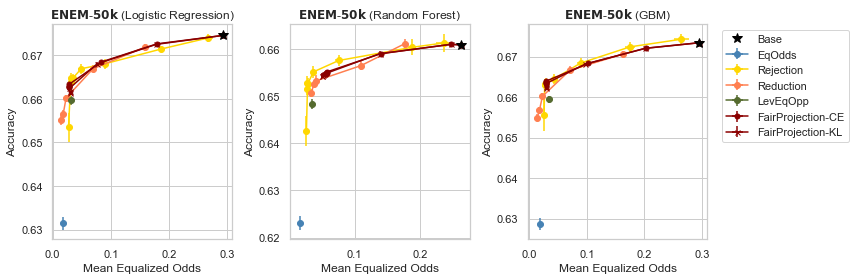

In [9]:
dataset = 'enem'
fair = 'eo'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

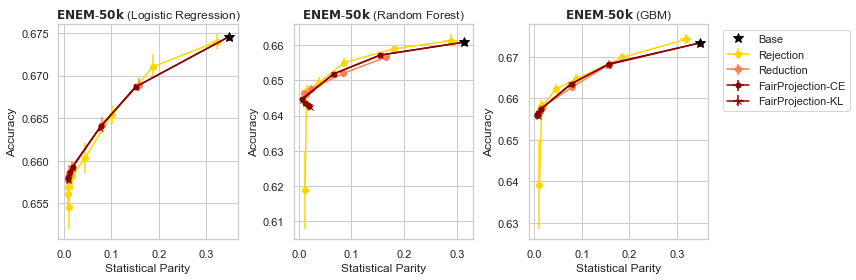

In [10]:
dataset = 'enem'
fair = 'sp'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

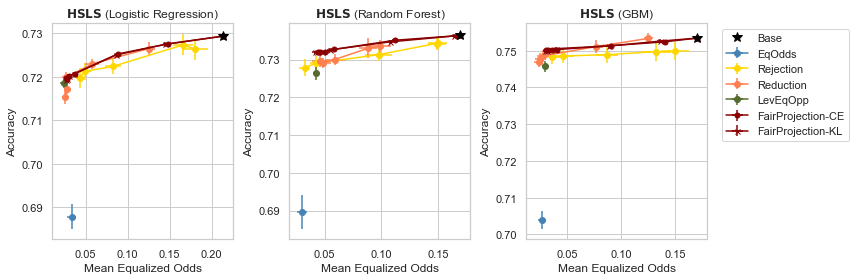

In [11]:
dataset = 'hsls'
fair = 'eo'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

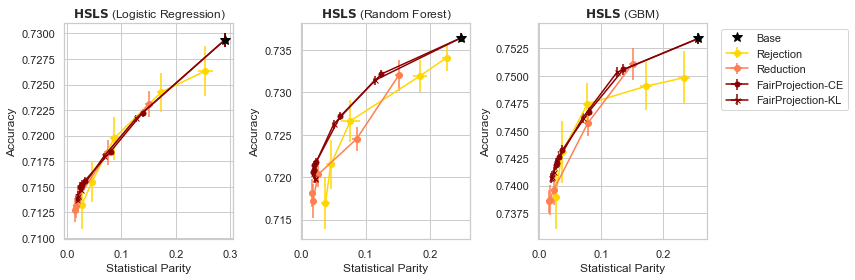

In [12]:
dataset = 'hsls'
fair = 'sp'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

#### Brier Score.. 

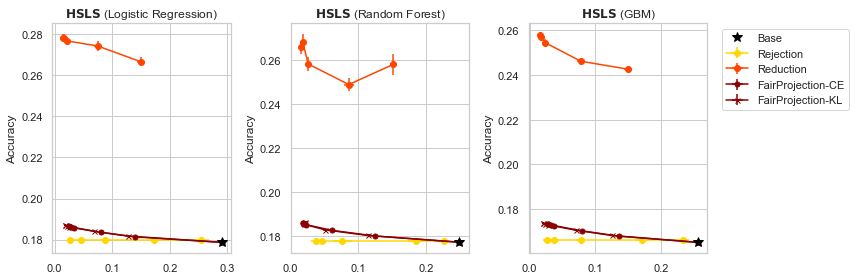

In [13]:
dataset = 'hsls'
fair = 'brier'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

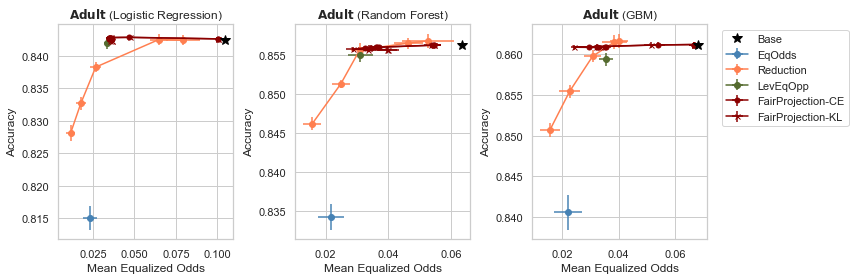

In [14]:
dataset = 'adult'
fair = 'eo'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

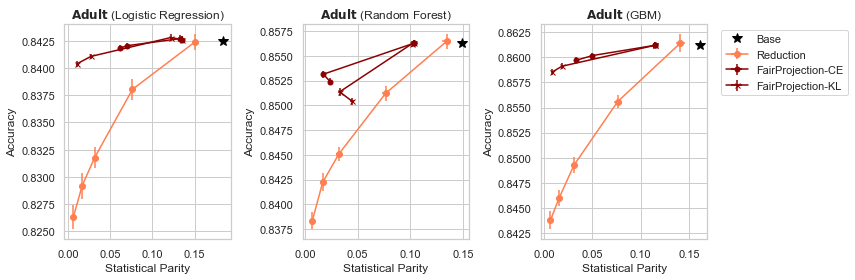

In [15]:
dataset = 'adult'
fair = 'sp'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

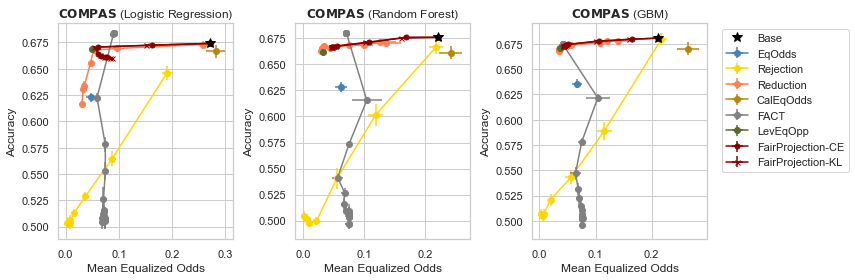

In [16]:
dataset = 'compas'
fair = 'eo'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

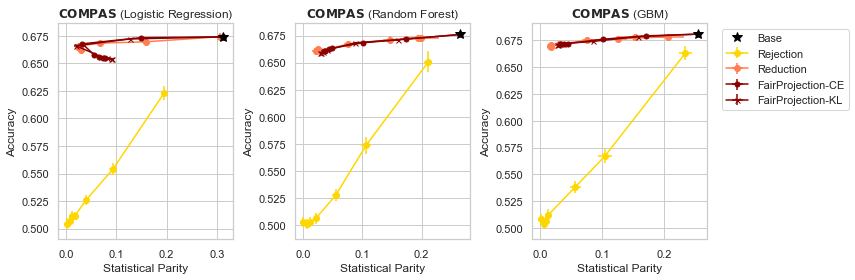

In [17]:
dataset = 'compas'
fair = 'sp'
mp_name = 'all'


fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_dataset(dataset, 'logit', axes[0], fair, mp_name)
plot_dataset(dataset, 'rf', axes[1], fair, mp_name)
plot_dataset(dataset, 'gbm', axes[2], fair, mp_name)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig(dataset+'-'+fair+'-'+mp_name +'.pdf')

## Multi-class Plots

In [18]:
with open('enem/benchmarks/results/enem-multi-50000-5-5-2022-05-23-21.17.05.pkl', 'rb+') as f: 
    enem_mp_multi = pickle.load(f)

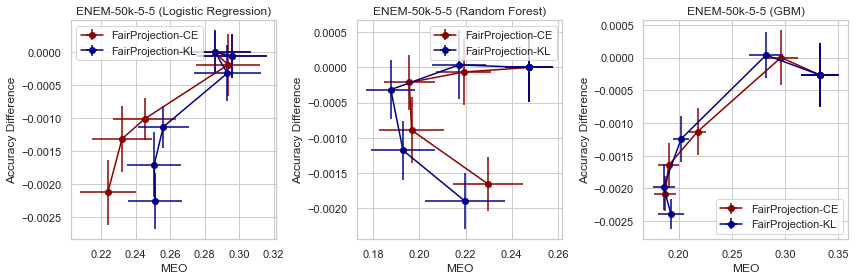

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

## Logistic Regression ##
ax = axes[0]
model = 'logit'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['logit_ce_meo']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['logit_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('MEO')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-5-5 (" + get_model_name(model) + ')')
ax.legend()


## Random Forest ##
ax = axes[1]
model = 'rf'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['rf_ce_meo']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['rf_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('MEO')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-5-5 (" + get_model_name(model) + ')')
ax.legend()


## GBM ##
ax = axes[2]
model = 'gbm'

idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['gbm_ce_meo']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['gbm_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('MEO')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-5-5 (" + get_model_name(model) + ')')
ax.legend()

plt.tight_layout()
plt.savefig('enem-50k-5-5-eo.pdf')


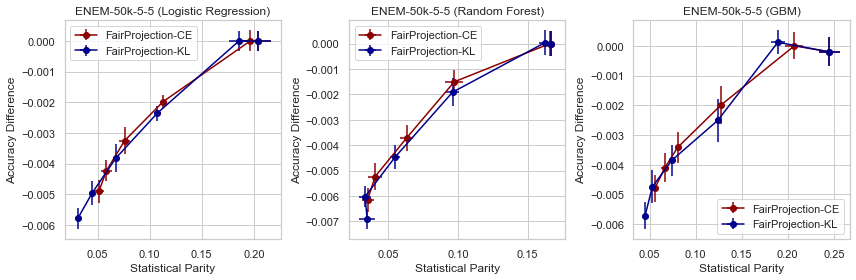

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

## Logistic Regression ##
ax = axes[0]
model = 'logit'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['logit_ce_sp']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['logit_kl_sp']
mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Statistical Parity')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-5-5 (" + get_model_name(model) + ')')
ax.legend()


## Random Forest ##
ax = axes[1]
model = 'rf'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['rf_ce_sp']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['rf_kl_sp']
mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Statistical Parity')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-5-5 (" + get_model_name(model) + ')')
ax.legend()


## GBM ##
ax = axes[2]
model = 'gbm'

idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['gbm_ce_sp']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['gbm_kl_sp']
mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Statistical Parity')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-5-5 (" + get_model_name(model) + ')')
ax.legend()

plt.tight_layout()
plt.savefig('enem-50k-5-5-sp.pdf')


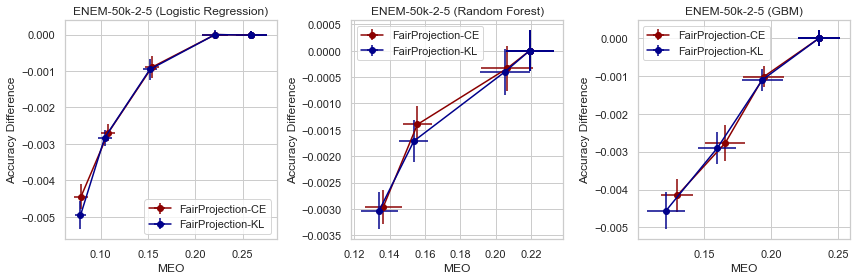

In [21]:
with open('enem/benchmarks/results/enem-multi-50000-2-5-2022-05-23-19.59.24.pkl', 'rb+') as f: 
    enem_mp_multi = pickle.load(f)
    
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

## Logistic Regression ##
ax = axes[0]
model = 'logit'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['logit_ce_meo']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['logit_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('MEO')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-2-5 (" + get_model_name(model) + ')')
ax.legend()


## Random Forest ##
ax = axes[1]
model = 'rf'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['rf_ce_meo']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['rf_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('MEO')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-2-5 (" + get_model_name(model) + ')')
ax.legend()


## GBM ##
ax = axes[2]
model = 'gbm'

idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['gbm_ce_meo']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['gbm_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('MEO')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-2-5 (" + get_model_name(model) + ')')
ax.legend()

plt.tight_layout()
plt.savefig('enem-50k-2-5-eo.pdf')


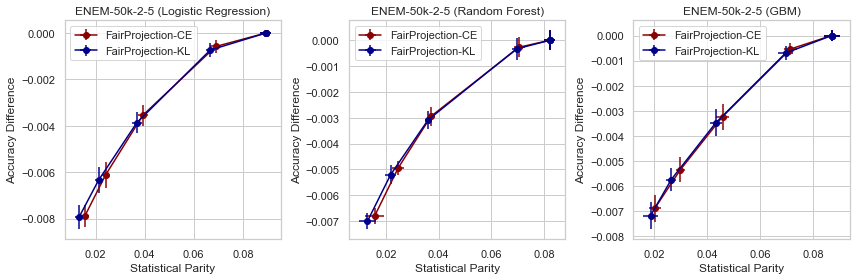

In [22]:
with open('enem/benchmarks/results/enem-multi-50000-2-5-2022-05-23-19.59.24.pkl', 'rb+') as f: 
    enem_mp_multi = pickle.load(f)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

## Logistic Regression ##
ax = axes[0]
model = 'logit'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['logit_ce_sp']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['logit_kl_sp']
mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Statistical Parity')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-2-5 (" + get_model_name(model) + ')')
ax.legend()


## Random Forest ##
ax = axes[1]
model = 'rf'
idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['rf_ce_sp']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['rf_kl_sp']
mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Statistical Parity')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-2-5 (" + get_model_name(model) + ')')
ax.legend()


## GBM ##
ax = axes[2]
model = 'gbm'

idx_projection = np.arange(len(enem_mp_multi['tolerance']))
mp = enem_mp_multi['gbm_ce_sp']
acc_max = mp['acc'].mean(axis=1).max()

mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['gbm_kl_sp']
mean_se = compute_mean_se(mp, 'sp', 'acc')

ax.errorbar(mean_se[0][idx_projection]/2.5, (-acc_max +mean_se[1][idx_projection])/2.5,
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection]/2.5, color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Statistical Parity')
ax.set_ylabel('Accuracy Difference')
ax.set_title(r"ENEM-50k-2-5 (" + get_model_name(model) + ')')
ax.legend()

plt.tight_layout()
plt.savefig('enem-50k-2-5-sp.pdf')


### Adversarial vs. FairProjection (ENEM50k-)

In [23]:
with open('enem/benchmarks/results/enem-multi-50000-5-2-2022-05-23-18.20.26.pkl', 'rb+') as f: 
    enem_mp_multi = pickle.load(f)

with open('enem/benchmarks/results/adversarial.pkl', 'rb+') as f: 
    adversarial = pickle.load(f)
    
acc_mean = np.array([np.mean(d['acc']) for d in adversarial])
acc_se = np.array([sem(d['acc']) for d in adversarial])
ad_acc_max = np.max(acc_mean)

meo_mean = np.array([np.mean(d['meo_abs']) for d in adversarial])
meo_se = np.array([sem(d['meo_abs']) for d in adversarial])



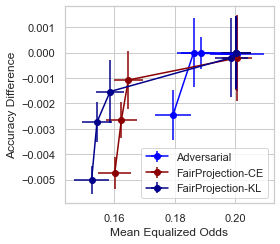

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))
idx_ad = [1,4, 5,6]
ax.errorbar(meo_mean[idx_ad]/2.5, (-ad_acc_max+acc_mean[idx_ad]),
      xerr = meo_se[idx_ad]/2.5, yerr = acc_se[idx_ad], marker='o', 
      label='Adversarial', color='blue')

mp = enem_mp_multi['logit_ce_meo']
idx_projection = np.arange(6)
mean_se = compute_mean_se(mp, 'meo', 'acc')
mp_acc_max = np.max(mean_se[1])

ax.errorbar(mean_se[0][idx_projection]/2.5, (-mp_acc_max +mean_se[1][idx_projection]),
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection], color='darkred', 
      marker='o', label='FairProjection-CE')

mp = enem_mp_multi['logit_kl_meo']
mean_se = compute_mean_se(mp, 'meo', 'acc')
mp_acc_max = np.max(mean_se[1])

ax.errorbar(mean_se[0][idx_projection]/2.5, (-mp_acc_max +mean_se[1][idx_projection]),
      xerr = mean_se[2][idx_projection]/2.5, yerr = mean_se[3][idx_projection], color='darkblue', 
      marker='o', label='FairProjection-KL')

ax.set_xlabel('Mean Equalized Odds')
ax.set_ylabel('Accuracy Difference')
# plot_mp(ax, mp, 'meo', 'acc', idx_projection, '', 'o', 'darkred')
ax.legend(loc='lower right')

plt.tight_layout()
fig.savefig('enem-multi-adv.pdf')